# GRU-6

## Hyperparameter tuning

- 1D convolutional layer + batch normalization + maxPooling : 2

- Hidden dimension : 256

- Number of channels : 128

- Loss function : Cross Entropy Loss

- Training epochs : 20

- Batch size : 100

- Learning rate : 1e-4

- Optimizer : Adam

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import numpy as np

import math

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torchaudio.datasets import SPEECHCOMMANDS
import os

In [ ]:
#Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Split of the dataset and data preparation
The class SubsetSC splits the Speech Commands Dataset into train, validation and test sets. The classification of the audio files in each set is specified in the 'validation.txt' and 'testing.txt' files where are written the paths of them.

In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [ ]:
# Create training, validation and testing split of the data
train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

#Tuple made of waveform, sample rate, label (spoken word), speaker ID and number of the utterance.
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
#List of labels in the dataset (commands said by speakers)
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [ ]:
#Downsampling from 16kHz to 8kHz
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

# Batched tensors for the model
To transform an array of data point made of audio and labels into two batched tensors for the model. The function collate_fn is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches.

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 100

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# GRU-6 Model

In [ ]:
class GRU_6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=256, n_channel=128, nhead=4, num_layer=6):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2 * n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        return self.fc1(hnn[-1])

model = GRU_6(n_input=transformed.shape[0], n_output=len(labels))
model.cuda()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 513443


# Training and testing
In this case we use SGD optimizer without weight decay and Negative Log Likelihood as loss function.

In [ ]:
lr = 1e-4

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
loss_f = torch.nn.CrossEntropyLoss()

In [ ]:
def train(epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.cuda()
        target = target.cuda()

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # Cross Entropy Loss for a tensor of size (batch x 1 x n_output)
        loss = loss_f(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())


In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


@torch.no_grad()
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    correct = 0
    n = 0
    for data, target in data_source:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        total_loss += target.numel() * loss_f(output.squeeze(), target).item()
        n += target.numel()

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
    
 
    accuracy = 100 * correct / len(test_loader.dataset)
    
    return total_loss / n, accuracy

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.564019
Train Epoch: 1 [10000/84843 (12%)]	Loss: 3.511328
Train Epoch: 1 [20000/84843 (24%)]	Loss: 3.481777
Train Epoch: 1 [30000/84843 (35%)]	Loss: 3.484685
Train Epoch: 1 [40000/84843 (47%)]	Loss: 3.500872
Train Epoch: 1 [50000/84843 (59%)]	Loss: 3.486960
Train Epoch: 1 [60000/84843 (71%)]	Loss: 3.468467
Train Epoch: 1 [70000/84843 (82%)]	Loss: 3.430421
Train Epoch: 1 [80000/84843 (94%)]	Loss: 3.336435
| Validation | val loss  3.20 | val accuracy 9%
Train Epoch: 2 [0/84843 (0%)]	Loss: 3.187900
Train Epoch: 2 [10000/84843 (12%)]	Loss: 3.120212
Train Epoch: 2 [20000/84843 (24%)]	Loss: 3.088478
Train Epoch: 2 [30000/84843 (35%)]	Loss: 2.852474
Train Epoch: 2 [40000/84843 (47%)]	Loss: 2.716795
Train Epoch: 2 [50000/84843 (59%)]	Loss: 2.489986
Train Epoch: 2 [60000/84843 (71%)]	Loss: 2.254714
Train Epoch: 2 [70000/84843 (82%)]	Loss: 2.106016
Train Epoch: 2 [80000/84843 (94%)]	Loss: 2.160721
| Validation | val loss  2.17 | val accuracy 34%
Train Epoch: 

Text(0.5, 1.0, 'training loss')

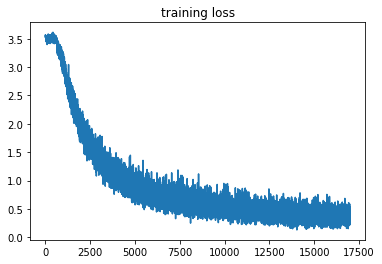

In [ ]:
best_val_loss = float("inf")
losses = []

log_interval = 100
n_epoch = 20


#The transform needs to live on the same device as the model and the data.
transform = transform.to(device)

for epoch in range(1, n_epoch + 1):
    train(epoch, log_interval)
    val_loss, val_acc = evaluate(val_loader)

    print(f'| Validation | val loss {val_loss:5.2f} | val accuracy {val_acc:.0f}%')

    if val_loss < best_val_loss:
      with open("GRU-3_8kHz.pth", 'wb') as f:
        torch.save(model, f)
      best_val_loss = val_loss

with open("GRU-3_8kHz.pth", 'rb') as f:
  model = torch.load(f)

with torch.no_grad():
  test_loss, test_acc = evaluate(test_loader)

print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}%')
print('=' * 89)

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.240781
Train Epoch: 1 [10000/84843 (12%)]	Loss: 0.380979
Train Epoch: 1 [20000/84843 (24%)]	Loss: 0.371866
Train Epoch: 1 [30000/84843 (35%)]	Loss: 0.370553
Train Epoch: 1 [40000/84843 (47%)]	Loss: 0.336193
Train Epoch: 1 [50000/84843 (59%)]	Loss: 0.287755
Train Epoch: 1 [60000/84843 (71%)]	Loss: 0.312064
Train Epoch: 1 [70000/84843 (82%)]	Loss: 0.240911
Train Epoch: 1 [80000/84843 (94%)]	Loss: 0.318081
| Validation | val loss  0.42 | val accuracy 79%
Train Epoch: 2 [0/84843 (0%)]	Loss: 0.308933
Train Epoch: 2 [10000/84843 (12%)]	Loss: 0.372981
Train Epoch: 2 [20000/84843 (24%)]	Loss: 0.359565
Train Epoch: 2 [30000/84843 (35%)]	Loss: 0.366990
Train Epoch: 2 [40000/84843 (47%)]	Loss: 0.355083
Train Epoch: 2 [50000/84843 (59%)]	Loss: 0.345742
Train Epoch: 2 [60000/84843 (71%)]	Loss: 0.270578
Train Epoch: 2 [70000/84843 (82%)]	Loss: 0.289530
Train Epoch: 2 [80000/84843 (94%)]	Loss: 0.400263
| Validation | val loss  0.42 | val accuracy 79%
Train Epoch:

Text(0.5, 1.0, 'training loss')

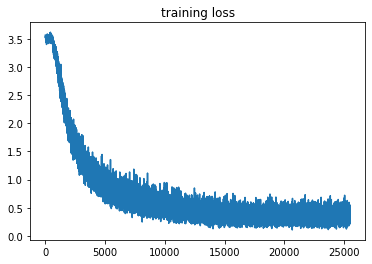

In [ ]:
n_epoch = 10
for epoch in range(1, n_epoch + 1):
    train(epoch, log_interval)
    val_loss, val_acc = evaluate(val_loader)

    print(f'| Validation | val loss {val_loss:5.2f} | val accuracy {val_acc:.0f}%')

    if val_loss < best_val_loss:
      with open("GRU-3_8kHz.pth", 'wb') as f:
        torch.save(model, f)
      best_val_loss = val_loss

with open("GRU-3_8kHz.pth", 'rb') as f:
  model = torch.load(f)

with torch.no_grad():
  test_loss, test_acc = evaluate(test_loader)

print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}%')
print('=' * 89)

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")